In [ ]:
!pip install scikeras

In [ ]:
import pandas as pd
import csv
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Loading dataset

In [ ]:
df = pd.read_csv("mlcData100k.csv", quoting=csv.QUOTE_NONE)
df

,settlingTime,unsettled,overshoot,overshootTime,crossCount,riseTime,Kp,Kd,J
0,14.8,0,-1.005233,15.7,1,11.9,0.05,0.2,10000.0
1,14.8,0,-1.039072,15.7,1,12.0,0.05,0.2,10200.0
2,99.0,1,1.004262,25.2,1,12.0,0.05,0.2,10400.0
3,99.0,1,1.014865,25.3,1,12.0,0.05,0.2,10600.0
4,99.0,1,1.025075,25.3,1,12.0,0.05,0.2,10800.0
...,...,...,...,...,...,...,...,...,...
108166,30.1,0,12.443609,21.5,2,13.8,0.18,0.6,29200.0
108167,30.3,0,12.626859,21.6,2,13.9,0.18,0.6,29400.0
108168,30.5,0,12.801826,21.7,2,13.9,0.18,0.6,29600.0
108169,30.7,0,12.985981,21.8,2,13.9,0.18,0.6,29800.0


In [ ]:
dataset = df.values
X = dataset[:, 0:8]
Y = dataset[:, 8]

Splitting data to Train (65%), Val(25%), Test(10%)

In [ ]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.35)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.285)
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(70311, 8) (27069, 8) (10791, 8) (70311,) (27069,) (10791,)


# Building the model architecture

Function to create a base model

In [ ]:
def base_model():
  model = Sequential([
      Dense(8, activation='relu', input_shape=(8,), kernel_initializer='normal'),
      Dense(1, kernel_initializer='normal')
  ])

  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

testing the architecture

In [ ]:
estimator = KerasRegressor(model=base_model, epochs=25, batch_size=64)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

LARGER MODEL

In [ ]:
def large_model():
  model = Sequential([
      Dense(96, activation='relu', input_shape=(8,)),
      Dense(128, activation='relu'),
      Dense(96, activation='relu'),
      Dense(1, activation='linear')
  ])

  model.compile(loss='mean_squared_error', optimizer='adam',  metrics=['mean_squared_error'])
  return model

Testing larger model with Standardization of data

In [ ]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=large_model, epochs=20, batch_size=72, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
print("Large Model: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Large Model: -971524.82 (67520.38) MSE


Select model and train it

In [ ]:
selected_model = large_model()
hist = selected_model.fit(X_train, Y_train, epochs=25, batch_size=100, validation_data=(X_val, Y_val))


Epoch 1/25
704/704 [==============================] - 4s 4ms/step - loss: 76408552.0000 - mean_squared_error: 76408552.0000 - val_loss: 26012974.0000 - val_mean_squared_error: 26012974.0000
Epoch 2/25
704/704 [==============================] - 2s 3ms/step - loss: 25603086.0000 - mean_squared_error: 25603086.0000 - val_loss: 24663478.0000 - val_mean_squared_error: 24663478.0000
Epoch 3/25
704/704 [==============================] - 3s 5ms/step - loss: 24534962.0000 - mean_squared_error: 24534962.0000 - val_loss: 23757816.0000 - val_mean_squared_error: 23757816.0000
Epoch 4/25
704/704 [==============================] - 3s 4ms/step - loss: 23726610.0000 - mean_squared_error: 23726610.0000 - val_loss: 23342778.0000 - val_mean_squared_error: 23342778.0000
Epoch 5/25
704/704 [==============================] - 2s 3ms/step - loss: 23203266.0000 - mean_squared_error: 23203266.0000 - val_loss: 22848782.0000 - val_mean_squared_error: 22848782.0000
Epoch 6/25
704/704 [==============================

Evaluating the trained model

In [ ]:
selected_model.evaluate(X_test, Y_test)[1]

338/338 [==============================] - 1s 2ms/step - loss: 1268191.8750 - mean_squared_error: 1268191.8750


1268191.875

In [ ]:
#SAVING MODEL
selected_model.save('JPredictor.keras')



Visualising performance

We want to visualize the training loss and the validation loss like this:

In [ ]:
import matplotlib.pyplot as plt

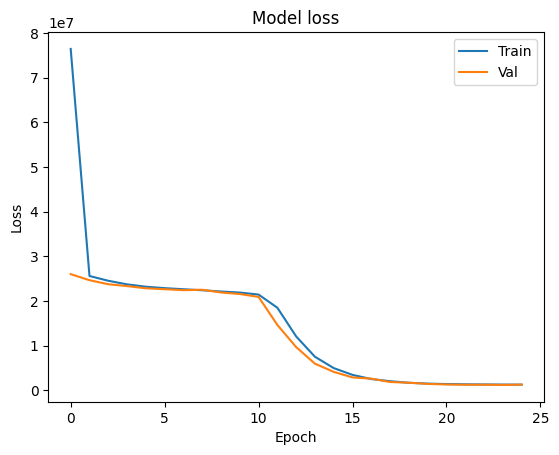

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

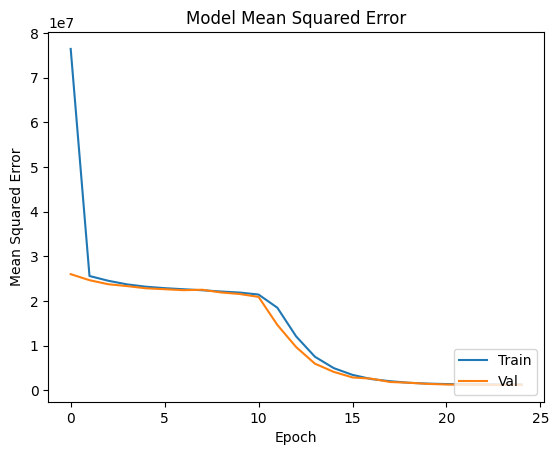

In [ ]:
plt.plot(hist.history['mean_squared_error'])
plt.plot(hist.history['val_mean_squared_error'])
plt.title('Model Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
prediction = selected_model.predict(X_test)
prediction

338/338 [==============================] - 1s 2ms/step


array([[28601.566],
       [22234.47 ],
       [28648.637],
       ...,
       [24241.229],
       [20577.166],
       [18570.473]], dtype=float32)

In [ ]:
trypredict = selected_model.predict([[19.6, 0, 2.525957955690423, 17.3, 2, 13.0, 0.1, 0.4]])
trypredict[0][0]

1/1 [==============================] - 0s 423ms/step


22241.584

In [ ]:
results = [[round(prediction[i][0]),Y_test[i]] for i in range(len(prediction))]
results

[[28602, 29400.0],
 [22234, 22200.0],
 [28649, 29600.0],
 [29250, 29800.0],
 [28804, 30000.0],
 [17850, 19200.0],
 [11950, 10400.0],
 [15783, 16200.0],
 [18034, 20800.0],
 [21237, 24400.0],
 [29059, 28400.0],
 [12805, 12400.0],
 [25417, 24800.0],
 [21734, 21600.0],
 [25141, 25600.0],
 [26345, 26800.0],
 [28191, 28800.0],
 [21607, 21600.0],
 [18441, 18600.0],
 [10544, 10600.0],
 [14926, 14600.0],
 [15963, 19400.0],
 [10731, 11200.0],
 [26001, 18600.0],
 [25017, 25400.0],
 [17932, 18000.0],
 [17897, 17600.0],
 [25889, 26400.0],
 [26108, 25800.0],
 [13806, 14400.0],
 [24569, 24400.0],
 [19355, 19200.0],
 [11947, 12000.0],
 [19407, 18800.0],
 [22922, 23000.0],
 [21462, 21400.0],
 [11015, 11200.0],
 [15099, 13400.0],
 [24778, 25800.0],
 [18436, 18400.0],
 [19887, 17800.0],
 [10491, 10400.0],
 [14609, 14600.0],
 [22845, 22400.0],
 [19901, 19800.0],
 [12130, 12400.0],
 [12711, 10400.0],
 [18789, 18600.0],
 [22553, 21600.0],
 [23041, 22800.0],
 [16779, 16600.0],
 [10927, 11200.0],
 [21447, 216

In [ ]:
#MEAN ERROR
sum = 0
for i in range(len(results)):
  error = abs(results[i][1]- results[i][0])
  sum+=error
avg = round(sum/len(results),2)
avg

653.22

# Map J to Kp, Kd

In [ ]:
import random
import json
with open("lookup.json", 'r') as f:
    lookupDict = json.load(f)
def lookup(J):

    if J>30000:
      J = 30000
      print("WARNING: J out of range (lower)")
    if J<10200:
      J = 10200
      print("WARNING: J out of range (higher)")

    J = float(J - J%200 + (0 if J%200<110 else 200))
    return random.choice(lookupDict[str(J)])

In [ ]:
for dat in prediction:

  print(dat, lookup(dat))

Streaming output truncated to the last 5000 lines.
[16000.333] [0.15660000000000002, 0.58]
[15658.633] [0.1462, 0.52]
[8853.97] [0.1722, 0.49999999999999994]
[11383.413] [0.076, 0.24]
[13729.351] [0.1774, 0.5999999999999999]
[21815.291] [0.10980000000000001, 0.45999999999999996]
[29491.371] [0.0656, 0.32]
[16400.826] [0.1644, 0.5999999999999999]
[27929.518] [0.0552, 0.26]
[26956.424] [0.1306, 0.5999999999999999]
[19136.305] [0.14100000000000001, 0.5599999999999999]
[23901.428] [0.0552, 0.24]
[12091.421] [0.1072, 0.33999999999999997]
[25204.107] [0.13319999999999999, 0.5999999999999999]
[16538.703] [0.1462, 0.54]
[9772.492] [0.15139999999999998, 0.43999999999999995]
[27299.025] [0.1254, 0.58]
[10852.956] [0.18, 0.54]
[21696.69] [0.1358, 0.5599999999999999]
[14455.001] [0.07339999999999999, 0.26]
[13733.902] [0.1774, 0.5999999999999999]
[25437.041] [0.128, 0.58]
[17975.656] [0.1306, 0.49999999999999994]
[26538.658] [0.1306, 0.5999999999999999]
[10845.222] [0.18, 0.54]
[23540.299] [0.0786